In [1]:
from tabulate import tabulate
from scipy.interpolate import interp1d
import numpy as np
import math
from MAPScorer import MAPScorer
from scipy import interp
from scipy.interpolate import interp1d
from mySVMKfold import MySVM
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score, precision_recall_fscore_support, f1_score, accuracy_score, cohen_kappa_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
outputPlotDir = "plots/svm"

In [3]:
def _calculateMicroMacroCurve(curveFunction, yt, yp):
        n_classes = yt.shape[1]
        abscissa = dict()
        ordinate = dict()
        area = dict()
        for i in range(n_classes):
            abscissa[i], ordinate[i] = curveFunction(yt[:, i], yp[:, i])
            area[i] = auc(abscissa[i], ordinate[i])
        abscissa["micro"], ordinate["micro"] = curveFunction(yt.ravel(), yp.ravel())
        area["micro"] = auc(abscissa["micro"], ordinate["micro"])
        # aggregate all
        all_rec = list(filter(lambda x: not math.isnan(x), np.unique(np.concatenate([abscissa[i] for i in range(n_classes)]))))

        # interpolate all prec/rec curves at this points
        mean_ordinate = np.zeros_like(all_rec)
        representedClasses = 0
        unrepresentedClasses = 0
        for i in range(n_classes):
            interp = interp1d(abscissa[i], ordinate[i])
            curr_ordinate = interp(all_rec)
            if not np.any([math.isnan(x) for x in abscissa[i]]) and not np.any([math.isnan(x) for x in ordinate[i]]):
                mean_ordinate += curr_ordinate
                representedClasses += 1
            else:
                unrepresentedClasses += 1

        # average it and compute AUC
        mean_ordinate /= representedClasses

        abscissa["macro"] = all_rec
        ordinate["macro"] = mean_ordinate
        area["macro"] = auc(abscissa["macro"], ordinate["macro"])

        return (abscissa, ordinate, area)

In [4]:
svm = MySVM()
svm.extractData()

Splitting data


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [5]:
tasks = ['sede1', 'sede2', 'sede12', 'morfo1', 'morfo2', 'morfo12']
yp = {}
ycn = {}
yc = {}
ytn = {}
yt = {}
na = 'N/A'
metrics = {}

rec = {}
pre = {}
pr_auc = {}
fpr = {}
tpr = {}
roc_auc = {}

for stra in range(svm.stratifications):
    print("Stratification {}".format(stra))
    svm.createModels(stra)

    metrics[stra] = {}
    rec[stra] = {}
    pre[stra] = {}
    pr_auc[stra] = {}
    fpr[stra] = {}
    tpr[stra] = {}
    roc_auc[stra] = {}
    
    for task in tasks:
        print(task)
        XTest = svm.X[svm.testIndexes[task][stra]]
        yTest = svm.y[task][svm.testIndexes[task][stra]]
        
        yp[task] = svm.model[task].decision_function(XTest)
        yt[task] = yTest    
        ytn[task] = svm.lb[task].inverse_transform(yt[task])
        yc[task] = np.zeros(yt[task].shape, np.int)
        for i,p in enumerate(yp[task]):
            yc[task][i][np.argmax(p)] = 1
        ycn[task] = svm.lb[task].inverse_transform(yc[task])
        
        metrics[stra][task] = {}
        metrics[stra][task][na] = {}
        metrics[stra][task][na]['meanAvgPrec'] = MAPScorer().score(ytn[task], ycn[task])
        metrics[stra][task][na]['accuracy'] = accuracy_score(yt[task], yc[task])
        metrics[stra][task][na]['kappa'] = cohen_kappa_score(ytn[task], ycn[task])
        for avg in ['micro', 'macro', 'weighted']:
            metrics[stra][task][avg] = {}
            metrics[stra][task][avg]['precision'], metrics[stra][task][avg]['recall'], metrics[stra][task][avg]['f1score'], metrics[stra][task][avg]['support'] = precision_recall_fscore_support(yt[task], yc[task], average=avg)

            rec[stra][task], pre[stra][task], pr_auc[stra][task] = _calculateMicroMacroCurve(lambda y,s: (lambda t: (t[1],t[0]))(precision_recall_curve(y,s)), yt[task], yp[task])
            fpr[stra][task], tpr[stra][task], roc_auc[stra][task] = _calculateMicroMacroCurve(lambda y,s: (lambda t: (t[0],t[1]))(roc_curve(y,s)), yt[task], yp[task])
        

Stratification 0
=========================== Categorical
------------------- sede1
------------------- sede2
------------------- sede12


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 38 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 41 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 43 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 92 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 102 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/si

------------------- morfo1


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 12 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 30 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 45 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 60 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site

------------------- morfo2
------------------- morfo12


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 10 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 18 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 21 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 28 is present in all training examples.
  str(classes[c]))
/home/trianam/anaconda3/lib/python3.6/site

sede1


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


sede2
sede12
morfo1
morfo2
morfo12
Stratification 1
=========================== Categorical
------------------- sede1
------------------- sede2
------------------- sede12
------------------- morfo1
------------------- morfo2
------------------- morfo12
sede1


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


sede2
sede12


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


morfo1
morfo2
morfo12
Stratification 2
=========================== Categorical
------------------- sede1
------------------- sede2
------------------- sede12
------------------- morfo1
------------------- morfo2
------------------- morfo12
sede1


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


sede2
sede12


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


morfo1
morfo2
morfo12
Stratification 3
=========================== Categorical
------------------- sede1
------------------- sede2
------------------- sede12
------------------- morfo1
------------------- morfo2
------------------- morfo12
sede1


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


sede2
sede12


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


morfo1
morfo2
morfo12
Stratification 4
=========================== Categorical
------------------- sede1
------------------- sede2
------------------- sede12
------------------- morfo1
------------------- morfo2
------------------- morfo12
sede1


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no

sede2
sede12
morfo1
morfo2
morfo12
Stratification 5
=========================== Categorical
------------------- sede1
------------------- sede2
------------------- sede12
------------------- morfo1
------------------- morfo2
------------------- morfo12
sede1


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no

sede2
sede12
morfo1
morfo2
morfo12
Stratification 6
=========================== Categorical
------------------- sede1
------------------- sede2
------------------- sede12
------------------- morfo1
------------------- morfo2
------------------- morfo12
sede1


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no

sede2
sede12
morfo1
morfo2
morfo12
Stratification 7
=========================== Categorical
------------------- sede1
------------------- sede2
------------------- sede12
------------------- morfo1
------------------- morfo2
------------------- morfo12
sede1


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no

sede2
sede12
morfo1
morfo2
morfo12
Stratification 8
=========================== Categorical
------------------- sede1
------------------- sede2
------------------- sede12
------------------- morfo1
------------------- morfo2
------------------- morfo12
sede1


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no

sede2
sede12
morfo1
morfo2
morfo12
Stratification 9
=========================== Categorical
------------------- sede1
------------------- sede2
------------------- sede12
------------------- morfo1
------------------- morfo2
------------------- morfo12
sede1


/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:415: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:613: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py:542: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/trianam/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no

sede2
sede12
morfo1
morfo2
morfo12


In [6]:
table = [["task", "average", "meanAvgPrec", "accuracy", "kappa", "precision", "recall", "f1score"]]


for task in tasks:
    table.append([" ", " ", " ", " ", " ", " ", " "])
    meanAvgPrec = 0
    accuracy = 0
    kappa = 0
    for stra in range(svm.stratifications):
        meanAvgPrec += metrics[stra][task][na]['meanAvgPrec']
        accuracy += metrics[stra][task][na]['accuracy']
        kappa += metrics[stra][task][na]['kappa']
    meanAvgPrec /= svm.stratifications
    accuracy /= svm.stratifications
    kappa /= svm.stratifications
    table.append([task, na, meanAvgPrec, accuracy, kappa, na, na, na])
    for avg in ['micro', 'macro', 'weighted']:
        precision = 0
        recall = 0
        f1score = 0
        for stra in range(svm.stratifications):
            precision += metrics[stra][task][avg]['precision']
            recall += metrics[stra][task][avg]['recall']
            f1score += metrics[stra][task][avg]['f1score']
        precision /= svm.stratifications
        recall /= svm.stratifications
        f1score /= svm.stratifications
        
        table.append([task, avg, na, na, na, precision, recall, f1score])
print(tabulate(table))
        

-------  --------  ------------------  ------------------  ------------------  -------------------  -------------------  -------------------
task     average   meanAvgPrec         accuracy            kappa               precision            recall               f1score

sede1    N/A       0.999308352410298   0.8981206364631072  0.8859891509693973  N/A                  N/A                  N/A
sede1    micro     N/A                 N/A                 N/A                 0.8981206364631072   0.8981206364631072   0.8981206364631072
sede1    macro     N/A                 N/A                 N/A                 0.6243504999657645   0.5322341002432207   0.5582416008716531
sede1    weighted  N/A                 N/A                 N/A                 0.8867572481163762   0.8981206364631072   0.8894049400414948

sede2    N/A       0.9678438576315832  0.723298962266476   0.4836700109022833  N/A                  N/A                  N/A
sede2    micro     N/A                 N/A                

In [7]:
for stra in range(10):
    print(fpr[stra][task]['micro'].shape)

(111336,)
(167305,)
(113277,)
(130469,)
(159453,)
(126413,)
(168873,)
(137332,)
(107021,)
(148749,)


In [8]:
titles = {
    'sede1':'site', 
    'sede2':'subsite',
    'sede12':'full site',
    'morfo1':'type',
    'morfo2':'behaviour',
    'morfo12':'type/behaviour',
}

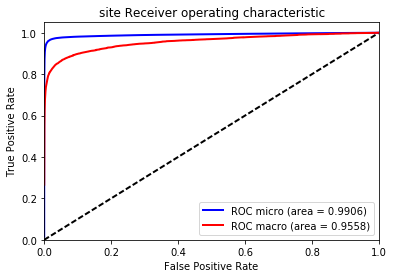

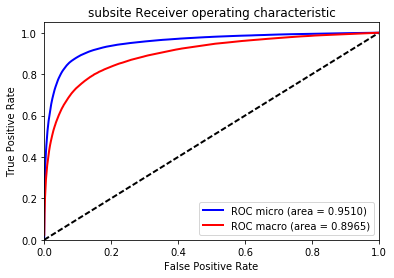

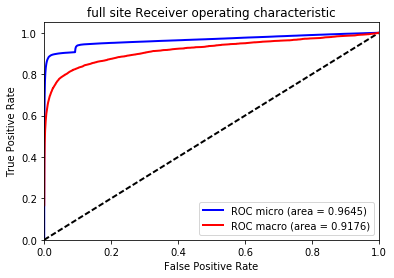

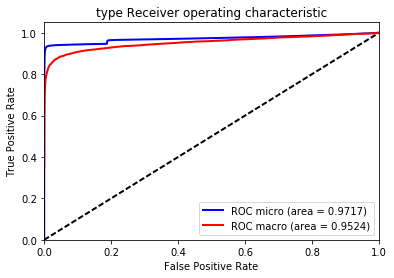

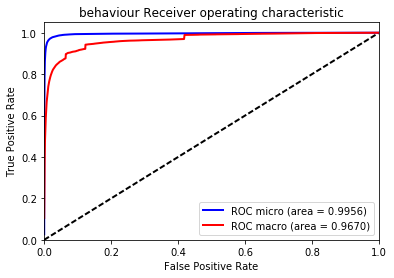

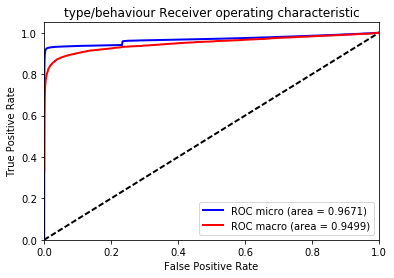

In [9]:
numPoints = 10000
for task in tasks:
    fprMicro = np.linspace(0, 1, numPoints)
    tprMicro = 0.
    aucMicro = 0.
    fprMacro = np.linspace(0, 1, numPoints)
    tprMacro = 0.
    aucMacro = 0.
    for stra in range(svm.stratifications):
        interp = interp1d(fpr[stra][task]['micro'], tpr[stra][task]['micro'])
        tprMicro += interp(fprMicro)
        aucMicro += roc_auc[stra][task]['micro']
        
        interp = interp1d(fpr[stra][task]['macro'], tpr[stra][task]['macro'])
        tprMacro += interp(fprMacro)
        aucMacro += roc_auc[stra][task]['macro']
    
    tprMicro /= svm.stratifications
    aucMicro /= svm.stratifications
    
    tprMacro /= svm.stratifications
    aucMacro /= svm.stratifications
    
    fig = plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(titles[task]+' Receiver operating characteristic')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    #for c in range(n_classes):
    #    plt.plot(fpr[c], tpr[c], lw=1, label='ROC curve {} (area = {:0.2f})'.format(c, roc_auc[2]))
    plt.plot(fprMicro, tprMicro, color='blue', lw=2, label='ROC micro (area = %0.4f)' % aucMicro)
    plt.plot(fprMacro, tprMacro, color='red', lw=2, label='ROC macro (area = %0.4f)' % aucMacro)
    plt.legend(loc="lower right")
    plt.savefig(outputPlotDir+"/roc-"+task+".pdf", bbox_inches='tight')
    plt.show()

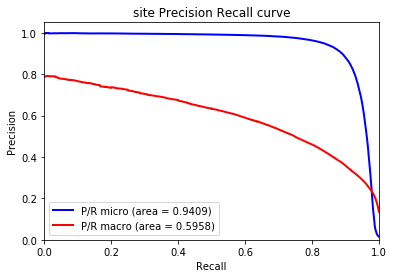

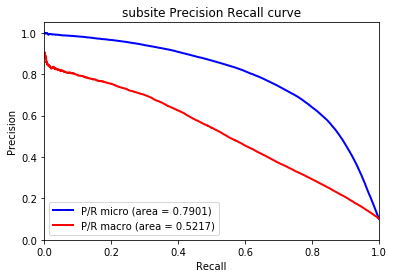

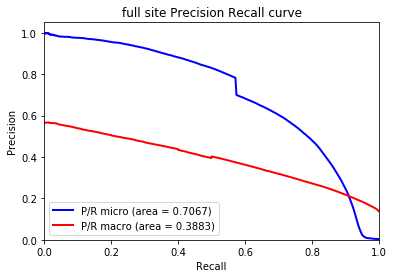

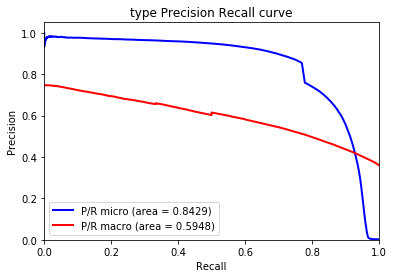

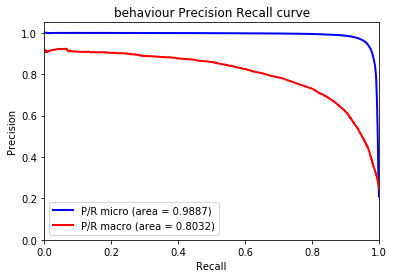

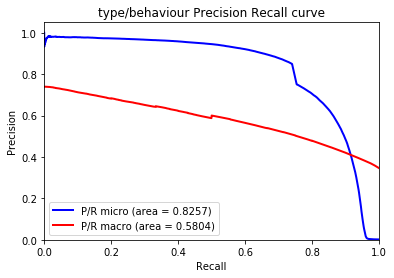

In [10]:
numPoints = 10000
for task in tasks:
    recMicro = np.linspace(0, 1, numPoints)
    preMicro = 0.
    aucMicro = 0.
    recMacro = np.linspace(0, 1, numPoints)
    preMacro = 0.
    aucMacro = 0.
    for stra in range(svm.stratifications):
        interp = interp1d(rec[stra][task]['micro'], pre[stra][task]['micro'])
        preMicro += interp(recMicro)
        aucMicro += pr_auc[stra][task]['micro']
        
        interp = interp1d(rec[stra][task]['macro'], pre[stra][task]['macro'])
        preMacro += interp(recMacro)
        aucMacro += pr_auc[stra][task]['macro']
        
    preMicro /= svm.stratifications
    aucMicro /= svm.stratifications
    preMacro /= svm.stratifications
    aucMacro /= svm.stratifications
    
    fig = plt.figure()
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
 
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(titles[task]+' Precision Recall curve')
    #for c in range(n_classes):
    #    plt.plot(rec[c], pre[c], lw=1, label='ROC curve {} (area = {:0.2f})'.format(c, pr_auc[2]))
    plt.plot(recMicro, preMicro, color='blue', lw=2, label='P/R micro (area = %0.4f)' % aucMicro)
    plt.plot(recMacro, preMacro, color='red', lw=2, label='P/R macro (area = %0.4f)' % aucMacro)
    plt.legend(loc="lower left")
    plt.savefig(outputPlotDir+"/pr-"+task+".pdf", bbox_inches='tight')
    plt.show()